# People Flow Detection using Object Tracking & Heatmap Visualization

This project implements a robust computer vision system to detect, track, and count people moving through a specific area in a video. It also generates a heatmap to visualize movement intensity across the frame. This can be applied to retail analytics, crowd monitoring, and smart surveillance systems.


## Input/Output Files

| File             | Description                                |
|------------------|--------------------------------------------|
| `people-walking.mp4` [Link](https://drive.google.com/file/d/1IiM2T7Lh0sdg4KVmfExsiN04vWxJYFq7/view?usp=sharing)| Input video file with human activity     |
| `output_video.mp4` [Link](https://drive.google.com/file/d/1l998QNjg42kQCo2G5p1-Ck3IZSF0WznY/view?usp=sharing)  | Annotated video with boxes and counters  |
| `heatmap.png` [Link](https://github.com/mdmahamudmredha/People-Flow-Detection-using-Object-Tracking-Heatmap-Visualization/blob/main/heatmap_enhanced.png)       | Generated heatmap of footfall patterns   |


## Key Objectives

- Detect individuals using a pre-trained YOLOv8 object detector.
- Track them frame-by-frame using the ByteTrack algorithm.
- Count the number of people entering and exiting through defined virtual lines.
- Generate a heatmap of movement density for spatial flow analysis.


## 🔧 Tools and Technologies Used

| Component      | Technology / Library         |
|----------------|-------------------------------|
| Detection      | YOLOv8 (Ultralytics)          |
| Tracking       | ByteTrack                     |
| Visualization  | Supervision, OpenCV           |
| Heatmap        | NumPy, Matplotlib             |
| Programming    | Python                        |
| Environment    | Jupyter Notebook              |


##  Project Workflow

### 1. **Object Detection with YOLOv8**

- Uses `yolov8n.pt`, a lightweight pre-trained model from the YOLOv8 family.
- Only class `0` (person) is considered for detection.
- Bounding boxes and confidence scores are generated per frame.

### 2. **Object Tracking with ByteTrack**

- Assigns unique ID to each detected person.
- Maintains identity across frames even under partial occlusion or movement.
- Implemented via `supervision` library's tracking wrapper.

### 3. **Line Crossing Logic for IN/OUT Counting**

Two virtual lines are defined horizontally in the frame:

| Line     | Position             | Role                        |
|----------|----------------------|-----------------------------|
| IN Line  | ⅓ height from top    | Detects people entering     |
| OUT Line | ⅔ height from top    | Detects people exiting      |

#### Movement Logic

- **IN:** Center y-coordinate crosses IN line downward (previous < line, current ≥ line).
- **OUT:** Center y-coordinate crosses OUT line upward (previous > line, current ≤ line).

Counts are tracked in real-time and updated on the output frame.

### 4. **Heatmap Generation**

- Collects all center points of tracked individuals.
- Plots them as a 2D histogram on the frame.
- Applies Gaussian smoothing and `'hot'` colormap using Matplotlib.
- Highlights zones with higher traffic density.


## Sample Output (Visual Description)

- **Output Video**
  - Green bounding boxes with object ID labels.
  - Blue and Red horizontal lines for IN and OUT zones.
  - Dynamic IN/OUT counters at the corner.

- **Heatmap**
  - Color gradient showing footfall concentration.
  - Brighter areas indicate high movement zones.


## Potential Use Cases
- Retail store customer flow analysis
- Entry-exit management in public venues
- Urban footfall monitoring
- Smart office space utilization
- Queue length and waiting time optimization

---

## Setup Instructions

Make sure the following libraries are installed:

```bash
pip install ultralytics supervision opencv-python numpy matplotlib


In [ ]:
!pip install opencv-python numpy ultralytics supervision matplotlib

# Import Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from supervision import ByteTrack, Color
import supervision as sv

  * `Ultralytics` – YOLO model interface
  * `Supervision` – for line zones and annotators
  * `OpenCV` – for video handling
  * `Matplotlib` – for heatmap generation

# Load YOLOv8n model

In [ ]:
model = YOLO("yolov8n.pt")

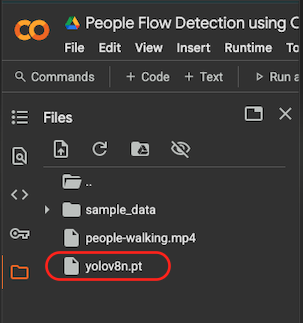

# Video input


In [ ]:
video_path = "/content/people-walking.mp4"
cap = cv2.VideoCapture(video_path)

Video Link: https://media.roboflow.com/supervision/video-examples/people-walking.mp4

# Get video properties


In [ ]:
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Video frame width in pixels
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Video frame height in pixels
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second (frame rate)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames

print("Video Properties:")
print(f"- Width: {width} pixels")
print(f"- Height: {height} pixels")
print(f"- FPS: {fps}")
print(f"- Total Frames: {total_frames}")

Video Properties:
- Width: 1920 pixels
- Height: 1080 pixels
- FPS: 25
- Total Frames: 341


# Define two Straight lines

In [ ]:
# Initialize tracker and counters
# tracker = ByteTrack()
# track_history = {}
# in_count, out_count = 0, 0
# heatmap = np.zeros((height, width), dtype=np.float32)

In [ ]:
LINE_Y1 = int(height * 0.35)  # 40 -> problem% from top
LINE_Y2 = int(height * 0.6)  # 60% from top
LINE_COLOR_UP = Color.GREEN
LINE_COLOR_DOWN = Color.RED

# Initialize counters, tracker, and history


In [ ]:
in_count = 0
out_count = 0
tracker = ByteTrack()
track_history = {}
counted_in_ids = set()
counted_out_ids = set()
heatmap = np.zeros((height, width), dtype=np.float32)

# Output video setup


In [ ]:
output_path = "output.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Line coordinates for counting


In [ ]:
line1 = sv.LineZone(start=sv.Point(0, LINE_Y1), end=sv.Point(width, LINE_Y1))
line2 = sv.LineZone(start=sv.Point(0, LINE_Y2), end=sv.Point(width, LINE_Y2))

# Frame processing


In [ ]:
total_unique_people = set()

def process_frame(frame, frame_num):
    global in_count, out_count, total_unique_people

    results = model(frame, classes=[0])[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = tracker.update_with_detections(detections)

    # Track unique IDs
    current_ids = set(detections.tracker_id)
    total_unique_people.update(current_ids)

    annotated_frame = frame.copy()

    for box, track_id in zip(detections.xyxy, detections.tracker_id):
        x1, y1, x2, y2 = map(int, box)
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        # Track history
        if track_id not in track_history:
            track_history[track_id] = []
        track_history[track_id].append((center_x, center_y))

        # Count IN/OUT once per person
        if len(track_history[track_id]) > 1:
            prev_x, prev_y = track_history[track_id][-2]
            curr_x, curr_y = track_history[track_id][-1]

            # IN
            if prev_y < LINE_Y1 and curr_y >= LINE_Y1 and track_id not in counted_in_ids:
                in_count += 1
                counted_in_ids.add(track_id)

            # OUT
            elif prev_y > LINE_Y2 and curr_y <= LINE_Y2 and track_id not in counted_out_ids:
                out_count += 1
                counted_out_ids.add(track_id)

        # Draw bounding boxes based on status
        if track_id in counted_in_ids:
            overlay = annotated_frame.copy()
            cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), -1)  # Green overlay
            alpha = 0.3
            cv2.addWeighted(overlay, alpha, annotated_frame, 1 - alpha, 0, annotated_frame)
            cv2.putText(annotated_frame, f"ID: {track_id}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        elif track_id in counted_out_ids:
            overlay = annotated_frame.copy()
            cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 0, 255), -1)  # Red overlay
            alpha = 0.3
            cv2.addWeighted(overlay, alpha, annotated_frame, 1 - alpha, 0, annotated_frame)
            cv2.putText(annotated_frame, f"ID: {track_id}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

        else:
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green
            cv2.putText(annotated_frame, f"ID: {track_id}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Draw IN/OUT lines
    cv2.line(annotated_frame, (0, LINE_Y1), (width, LINE_Y1), LINE_COLOR_UP.as_bgr(), 2)
    cv2.line(annotated_frame, (0, LINE_Y2), (width, LINE_Y2), LINE_COLOR_DOWN.as_bgr(), 2)

    # Draw white trajectory lines
    for person_id, points in track_history.items():
        if len(points) > 1:
            for i in range(1, len(points)):
                pt1 = points[i - 1]
                pt2 = points[i]
                cv2.line(annotated_frame, pt1, pt2, (255, 255, 255), 2)

    # Display larger counters
    cv2.putText(annotated_frame, f"IN: {in_count}", (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0, 255, 0), 3)
    cv2.putText(annotated_frame, f"OUT: {out_count}", (10, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0, 0, 255), 3)

     # Display TOTAL UNIQUE PEOPLE (নতুন টেক্সট)
    cv2.putText(annotated_frame, f"UNIQUE: {len(total_unique_people)}", (10, 200),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 0), 3)


    return annotated_frame

# Process video


In [ ]:
frame_num = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    annotated_frame = process_frame(frame, frame_num)
    out.write(annotated_frame)
    frame_num += 1

cap.release()
out.release()


0: 384x640 37 persons, 149.9ms
Speed: 3.7ms preprocess, 149.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 38 persons, 149.2ms
Speed: 4.7ms preprocess, 149.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 120.0ms
Speed: 2.6ms preprocess, 120.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 37 persons, 102.3ms
Speed: 2.4ms preprocess, 102.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 37 persons, 125.9ms
Speed: 2.4ms preprocess, 125.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 38 persons, 118.6ms
Speed: 2.3ms preprocess, 118.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 139.6ms
Speed: 3.6ms preprocess, 139.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 146.9ms
Speed: 3.5ms preprocess, 146.9ms inference, 2.1ms postproc

# Generate & save improved heatmap


In [ ]:
heatmap = np.zeros((height, width), dtype=np.float32)
for track_id in track_history:
    for center_x, center_y in track_history[track_id]:
        if 0 <= center_y < height and 0 <= center_x < width:
            heatmap[int(center_y), int(center_x)] += 1

# Gaussian blur for smoothing


In [ ]:
heatmap = cv2.GaussianBlur(heatmap, (21, 21), 10)

# Normalize heatmap
heatmap = np.clip(heatmap, 0, None)
if heatmap.max() > 0:
    heatmap = heatmap / heatmap.max()

# Visualize and save heatmap


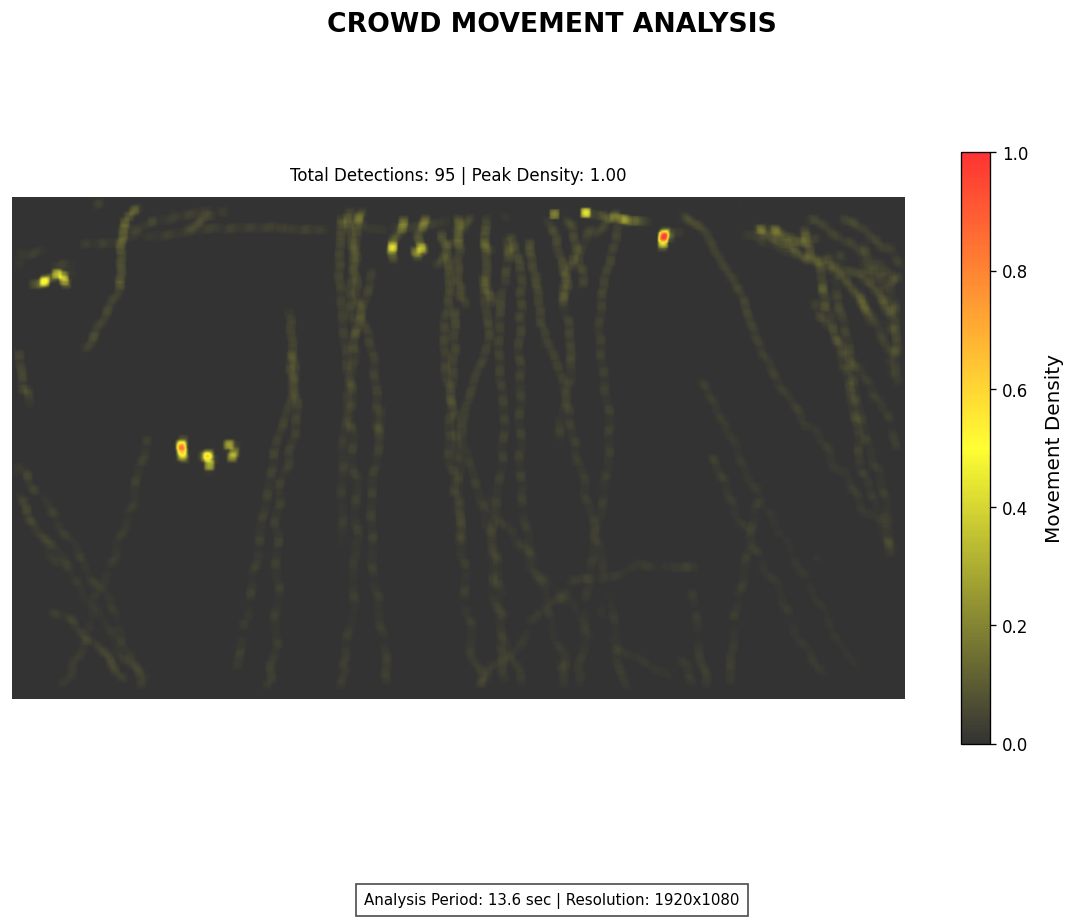

In [ ]:
plt.figure(figsize=(12, 8), dpi=120)

# Create custom colormap (yellow to red)
custom_cmap = plt.cm.colors.LinearSegmentedColormap.from_list('custom', ['#000000', '#FFFF00', '#FF0000'])

# Enhanced heatmap visualization
heatmap_plot = plt.imshow(heatmap,
                         cmap=custom_cmap,
                         interpolation='gaussian',
                         alpha=0.8,
                         vmin=0,
                         vmax=1)

# Add colorbar with professional styling
cbar = plt.colorbar(heatmap_plot, shrink=0.8)
cbar.set_label('Movement Density', fontsize=12, labelpad=10)
cbar.ax.tick_params(labelsize=10)

# Add title and subtitle with insights
plt.suptitle('CROWD MOVEMENT ANALYSIS', fontsize=16, fontweight='bold', y=0.95)
plt.title(f'Total Detections: {len(track_history)} | Peak Density: {heatmap.max():.2f}',
          fontsize=10, pad=10)

# Add grid lines for better spatial reference
plt.grid(visible=True, which='both',
         color='white', linestyle='--',
         linewidth=0.5, alpha=0.3)

# Add footer text
plt.figtext(0.5, 0.02,
           f"Analysis Period: {total_frames/fps:.1f} sec | Resolution: {width}x{height}",
           ha="center",
           fontsize=9,
           bbox={"facecolor":"white", "alpha":0.7, "pad":5})

plt.axis('off')

# Save high-quality output
plt.savefig('heatmap_enhanced.png',
            bbox_inches='tight',
            pad_inches=0.5,
            dpi=300,
            transparent=False)

plt.show()